In [ ]:
import numpy as np
import random
import os
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import pickle
import tensorflow as tf


from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import random
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

train_v2 = pickle.load(open('/content/drive/MyDrive/train_data_df_new.pkl', 'rb'))
train_jj = pickle.load(open('/content/drive/MyDrive/result_try.pkl', 'rb'))

In [ ]:
train = train_v2[['날짜','시가','고가','저가','종가','거래량','거래대금','등락률','종목코드']]
train

,날짜,시가,고가,저가,종가,거래량,거래대금,등락률,종목코드
0,2021-06-01,2890,2970,2885,2920,166690,487455970,1.040000,060310
1,2021-06-02,2915,2975,2830,2900,134833,388795625,-0.680000,060310
2,2021-06-03,2900,2925,2875,2900,144470,419668300,0.000000,060310
3,2021-06-04,2930,3120,2920,2950,934224,2840373820,1.720000,060310
4,2021-06-07,3000,3150,2955,3150,946560,2929678225,6.780000,060310
...,...,...,...,...,...,...,...,...,...
987995,2023-05-23,6710,6710,6420,6430,40981,266207710,-4.170000,238490
987996,2023-05-24,6400,6490,6210,6320,19392,123635550,-1.710000,238490
987997,2023-05-25,6340,6400,6270,6330,6457,40862130,0.160000,238490
987998,2023-05-26,6330,6410,6300,6330,8905,56621540,0.000000,238490


In [ ]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# # # 모든 열에 대해 inf 값을 NaN으로 대체
# # chg_train_df = loaded_train_df.replace([np.inf, -np.inf], np.nan)

# # # NaN 값을 가진 행을 제거
# # chg_train_df = chg_train_df.dropna()

# train_vif = train.drop(['종목코드','날짜'], axis=1)

# # VIF 계산을 위해 변수 간 다중공선성을 분석할 열을 선택
# X = train_vif.iloc[:].astype(float).values  # 시가와 종가 사이의 열만 선택 (시가총액 열 제외)

# # VIF 계산
# vif = pd.DataFrame()
# vif["features"] = train_vif.columns
# vif["VIF Factor"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
# vif = vif.sort_values(by="VIF Factor", ascending=False)
# vif

,features,VIF Factor
0,시가,6882.870103
2,저가,5362.978280
1,고가,4068.681543
3,종가,1192.884964
5,등락률,1.149238
4,거래량,1.042465


새벽에 든 생각.
일단 target을 15일 예측 가격 변동률로 하는 것이 맞는 것 같음.
왜? 가격 변동률이 나타내는건, 과거의 데이터에서 미래의 예상 변동률을 예측하는  것이 우리가 해야하는 것이다. 그러므로, 과거의 데이터로부터 우리가 맞춰야하는 15일 간의 예상 상승 하락 폭을 맞추는데 있어서 가장 필요한 것은 당연히 과거 15일의 데이터에서 미래의 패턴을 찾는 것이다.

내가 고쳐야할 방향, 일단 15일 뒤를 맞추기 위해, 패턴 학습을 시켜야함.
패턴 학습은 x데이터로 ohlcv를 넣고,

아니면 등락률의 10일간의 합을 이동평균을 내서, 미래값 예측?
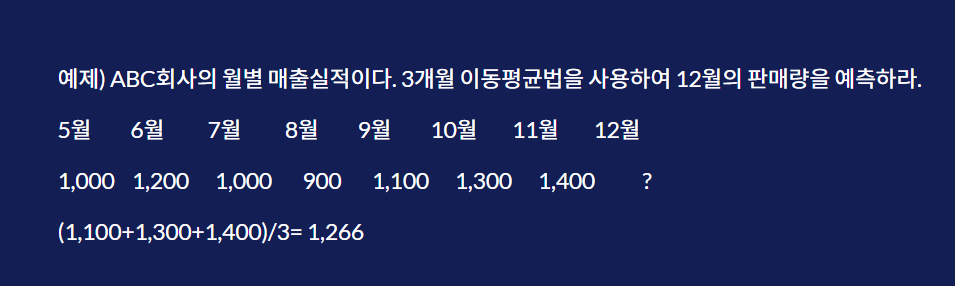

일단은 보류

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Reshape
# from keras.layers import Dropout

# def cnn_model(n_steps, n_features):
#     model = Sequential()
#     model.add(Reshape((n_steps * n_features, 1), input_shape=(n_steps * n_features,)))
#     model.add(Conv1D(32, kernel_size=5, activation='relu'))
#     model.add(MaxPooling1D(pool_size=1))
#     model.add(Dropout(0.1))

#     model.add(Conv1D(64, kernel_size=3, activation='relu'))
#     model.add(MaxPooling1D(pool_size=1))
#     model.add(Dropout(0.1))

#     model.add(Conv1D(128, kernel_size=3, activation='relu'))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.1))

#     model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dense(1))  # 출력 레이어의 노드 개수를 1로 설정

#     model.compile(loss='mse', optimizer='adam', metrics=['mse'])

#     return model

In [ ]:
train

,시가,고가,저가,거래량,거래대금,등락률,종가
날짜,,,,,,,
2021-06-08,2927.0,3028.0,2893.0,465355.4,1.413194e+09,1.772,3115
2021-06-09,2980.0,3070.0,2923.0,516567.8,1.580260e+09,1.342,3105
2021-06-10,3018.0,3131.0,2973.0,620735.8,1.922093e+09,1.414,3150
2021-06-11,3059.0,3183.0,3000.0,654647.2,2.033197e+09,1.704,3085
2021-06-14,3102.0,3194.0,3028.0,528299.4,1.652331e+09,0.948,3080
...,...,...,...,...,...,...,...
2022-12-23,2308.0,2345.0,2254.0,158928.8,3.628922e+08,-1.820,2175
2022-12-26,2272.0,2305.0,2212.0,166892.4,3.760483e+08,-1.774,2115
2022-12-27,2227.0,2266.0,2177.0,174684.8,3.875716e+08,-1.780,2195


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout

def cnn_model(num_features):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(num_features, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.1))

    model.add(Conv1D(128, kernel_size=2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))

    model.compile(loss='huber', optimizer='rmsprop', metrics=['mse'])

    return model

#==================================================================================
main_data = train_v2[['날짜','시가','고가','저가','종가','거래량','거래대금','등락률','종목코드']]
# train 데이터에 존재하는 독립적인 종목코드 추출
unique_codes = main_data['종목코드'].unique()

window_size = 5

result_df = pd.DataFrame()  # 결과를 저장할 데이터프레임 초기화

for code in tqdm(unique_codes):
    data = main_data[main_data['종목코드'] == code]
    data = data.drop(['종목코드'], axis=1)
    data.set_index('날짜', inplace=True)

    # 윈도우 사이즈와 롤링 윈도우 적용
    moving_vars = data.rolling(window=window_size).mean().shift(1)
    # 예측 대상인 종가를 제외한 피처들만 사용
    moving_vars = moving_vars.drop('종가', axis=1)

    # 실제 종가를 추가
    moving_vars['종가'] = data['종가']

    moving_vars = moving_vars.dropna()

    train = moving_vars[(moving_vars.index >= '2021-06-01') & (moving_vars.index <= '2022-12-31')]
    test = moving_vars[(moving_vars.index >= '2023-05-25') & (moving_vars.index <= '2023-05-29')]

    # 테스트 데이터셋이 비어있지 않은 경우에만 모델 학습 및 예측을 수행
    if not test.empty:
        X_train = train.drop('종가', axis=1)
        y_train = train['종가']
        X_test = test.drop('종가', axis=1)
        y_test = test['종가']

        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        model = cnn_model(6)
        print(f'Training model for code {code}...')
        model.fit(X_train_scaled, y_train)

        print(f'Predicting for code {code}...')
        predictions = model.predict(X_test_scaled)

        # 5월30일의 예측 종가와 5일간의 평균 종가 차이 계산
        average_close = y_test.mean()
        difference = average_close - predictions[-1]

        print(f"Code: {code}, Predicted Close on May 30: {predictions[-1]}, Average Close from May 25 to May 29: {average_close}, Difference: {difference}")

        # 결과를 데이터프레임에 추가
        result_row = pd.DataFrame({'종목코드': [code], 'Difference': [difference], '예측종가_5월30일': [predictions[-1]]})
        result_row['Rank'] = result_row['Difference'].rank(ascending=False)

        result_df = pd.concat([result_df, result_row])

# 결과를 데이터프레임을 CSV 파일로 저장
result_df.to_csv('/content/drive/MyDrive/Colab Notebooks/result.csv', index=False) #=>여기서의 Rank는 무시 (1로 채워짐)

    # # 다중 채널 1D CNN 모델에 입력할 형태로 데이터 변환
    # n_steps = 5  # 입력 시퀀스 길이 (과거 5일 종가를 기반으로 다음날 종가를 예측)
    # features = df.drop(["날짜", "종가"], axis=1).values  # 종가와 날짜를 제외한 특성
    # n_features = features.shape[1]  # 특성의 개수
    # X, y = [], []
    # for i in range(len(closing_prices_normalized) - n_steps):
    #     X.append(features[i : i + n_steps, :])
    #     y.append(closing_prices_normalized[i + n_steps])
    # X, y = np.array(X), np.array(y)

    # # 데이터 나누기 (훈련 데이터와 테스트 데이터)
    # X_train, X_test, y_train, y_test

    # # 다중 채널 1D CNN 모델 설계
    # model = cnn_model(n_steps, n_features)
    # # 모델 훈련
    # model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

    # # 테스트 데이터로 예측 수행
    # y_pred = model.predict(X_test)

    # # 예측 결과 저장
    # predicted_prices = scaler.inverse_transform(y_pred)
    # print("Predicted Prices:", predicted_prices.flatten())
    # break

  0%|          | 0/2000 [00:00<?, ?it/s]


ValueError: ignored

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(cnn_model, show_shapes=True)

In [ ]:
# def generate_time_splits(df, seq_length):
#     dates = df['날짜'].tolist()  # '날짜 컬럼명'은 실제 데이터프레임의 날짜 컬럼 이름으로 변경해야 합니다.
#     time_splits = []

#     for i in range(len(dates) - seq_length + 1):  # 마지막 시퀀스를 포함하기 위해 +1
#         start_date = dates[i]
#         end_date = dates[i + seq_length - 1]
#         time_splits.append((start_date, end_date))

#     return time_splits

# # df_ex = train[train['종목코드'] == '005930']
# # time_split = generate_time_splits(df_ex, 20)
#     # for (ts_start,ts_end) in time_split:


In [ ]:
#time_split코드 혹시몰라 살려두기
time_split = [
    # (pd.to_datetime('2021-06-01'), pd.to_datetime('2021-07-01')),
    # (pd.to_datetime('2021-07-02'), pd.to_datetime('2021-08-01')),
    # (pd.to_datetime('2021-08-02'), pd.to_datetime('2021-09-01')),
    # (pd.to_datetime('2021-09-02'), pd.to_datetime('2021-10-01')),
    # (pd.to_datetime('2021-10-02'), pd.to_datetime('2021-11-01')),
    # (pd.to_datetime('2021-11-02'), pd.to_datetime('2021-12-01')),
    # (pd.to_datetime('2021-12-02'), pd.to_datetime('2022-01-01')),
    # (pd.to_datetime('2022-01-02'), pd.to_datetime('2022-02-01')),
    # (pd.to_datetime('2022-02-02'), pd.to_datetime('2022-03-01')),
    # (pd.to_datetime('2022-03-02'), pd.to_datetime('2022-04-01')),
    # (pd.to_datetime('2022-04-02'), pd.to_datetime('2022-05-01')),
    # (pd.to_datetime('2022-05-02'), pd.to_datetime('2022-06-01')),
    # (pd.to_datetime('2022-06-02'), pd.to_datetime('2022-07-01')),
    # (pd.to_datetime('2022-07-02'), pd.to_datetime('2022-08-01')),
    # (pd.to_datetime('2022-08-02'), pd.to_datetime('2022-09-01')),
    # (pd.to_datetime('2022-09-02'), pd.to_datetime('2022-10-01')),
    # (pd.to_datetime('2022-10-02'), pd.to_datetime('2022-11-01')),
    # (pd.to_datetime('2022-11-02'), pd.to_datetime('2022-12-01')),
    # (pd.to_datetime('2022-12-02'), pd.to_datetime('2023-01-01')),
    # (pd.to_datetime('2023-01-02'), pd.to_datetime('2023-02-01')),
    # (pd.to_datetime('2023-02-02'), pd.to_datetime('2023-03-01')),
    # (pd.to_datetime('2023-03-02'), pd.to_datetime('2023-04-01')),
    # (pd.to_datetime('2023-04-02'), pd.to_datetime('2023-05-01')),
    # (pd.to_datetime('2023-05-02'), pd.to_datetime('2023-05-30')),
]

# start_date = pd.to_datetime('2021-06-01')
# end_date = pd.to_datetime('2023-05-30')

# current_date = start_date

# while current_date + pd.DateOffset(days=19) <= end_date:
#     time_split.append((current_date, current_date + pd.DateOffset(days=19)))
#     current_date += pd.DateOffset(days=1)

# print(time_split[-1])
# train['날짜'] = pd.to_datetime(train['날짜'])
# 각 종목코드에 대해서 모델 학습 및 추론 반복

In [ ]:
# #GPT 4 코드
# from tqdm import tqdm
# from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Reshape, Dropout

# def modified_cnn_model_v2(n_steps, n_features):
#     model = Sequential()
#     model.add(Conv1D(32, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
#     model.add(Dropout(0.1))
#     model.add(Conv1D(64, kernel_size=2, activation='relu'))
#     model.add(Dropout(0.1))
#     model.add(Conv1D(128, kernel_size=2, activation='relu'))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.1))
#     model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dense(1))
#     model.compile(loss='mse', optimizer='adam', metrics=['mse'])
#     return model

# # For the sake of demonstration, let's just run for the first 2 unique codes instead of all
# unique_codes_sample = train['종목코드'].unique()[:2]

# # Re-run the training and prediction process once more using the modified model
# results_modified = []

# for code in tqdm(unique_codes_sample):
#     data = train[train['종목코드'] == code]
#     data = data.drop(['종목코드'], axis=1)
#     df = data.sort_values("날짜")
#     closing_prices = df["종가"].values
#     scaler = MinMaxScaler()
#     closing_prices_normalized = scaler.fit_transform(closing_prices.reshape(-1, 1)).flatten()
#     n_steps = 5
#     features = df.drop(["날짜", "종가"], axis=1).values
#     n_features = features.shape[1]

#     X, y = [], []
#     for i in range(len(closing_prices_normalized) - n_steps):
#         X.append(features[i : i + n_steps, :])
#         y.append(closing_prices_normalized[i + n_steps])
#     X, y = np.array(X), np.array(y)

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#     model = modified_cnn_model_v2(n_steps, n_features)
#     model.fit(X_train, y_train, epochs=5, batch_size=1, verbose=1)

#     y_pred = model.predict(X_test)
#     predicted_prices = scaler.inverse_transform(y_pred)
#     results_modified.append(predicted_prices.flatten())

# results_modified

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/5
391/391 [==============================] - 2s 2ms/step - loss: nan - mse: nan
Epoch 2/5
391/391 [==============================] - 1s 2ms/step - loss: nan - mse: nan
Epoch 3/5
391/391 [==============================] - 1s 2ms/step - loss: nan - mse: nan
Epoch 4/5
391/391 [==============================] - 1s 3ms/step - loss: nan - mse: nan
Epoch 5/5
4/4 [==============================] - 0s 4ms/step


 50%|█████     | 1/2 [00:06<00:06,  6.71s/it]

Epoch 1/5
391/391 [==============================] - 3s 3ms/step - loss: 20675019080204288.0000 - mse: 20675019080204288.0000
Epoch 2/5
391/391 [==============================] - 1s 3ms/step - loss: 3726932369735680.0000 - mse: 3726932369735680.0000
Epoch 3/5
391/391 [==============================] - 1s 4ms/step - loss: 1926572810436608.0000 - mse: 1926572810436608.0000
Epoch 4/5
391/391 [==============================] - 1s 3ms/step - loss: 458365754933248.0000 - mse: 458365754933248.0000
Epoch 5/5
4/4 [==============================] - 0s 3ms/step


100%|██████████| 2/2 [00:14<00:00,  7.44s/it]


[array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan], dtype=float32),
 array([ 2.1361597e+09,  1.6513905e+10,  1.8910077e+09,  1.4653462e+09,
        -2.6551334e+08,  2.2934784e+10,  1.6099605e+11, -1.8214765e+09,
         3.9277719e+09,  2.2813491e+10,  8.8361411e+09,  5.1012490e+09,
         1.9717497e+10,  6.0551741e+10,  2.9109998e+10, -2.3943479e+10,
         1.9301835e+10,  7.0211446e+09,  6.4939832e+09,  6.6113188e+09,
         2.1375859e+10,  6.0924867e+09,  2.4713073e+10,  2.4697500e+0

In [ ]:
results_df = results_df.sort_values(by='차이', ascending=False)
results_df['종목코드'] = 'A' + results_df['종목코드']
results_df['순위'] = results_df['차이'].rank(method='first', ascending=False).astype('int') # 각 순위를 중복없이 생성
results_df

In [ ]:
#gpt의 코드.
# # 필요한 라이브러리를 import합니다.
# import numpy as np

# # 예측 모델을 위한 함수 (임의의 함수로 가정합니다)
# def predict_price(date):
#     # date를 기반으로 종가를 예측하는 모델 함수를 작성합니다.
#     # 예시로 랜덤하게 0~100 사이의 값을 반환합니다.
#     np.random.seed(date)
#     return np.random.randint(0, 100)

# # 5일 이동평균선을 계산하는 함수
# def moving_average(data):
#     return np.mean(data[-5:])

# # 미래 1일의 종가를 예측
# future_day_1 = predict_price(1)
# print("Day 1 Predicted Price:", future_day_1)

# # 5일 이동평균선 계산을 위해 사용할 데이터 (예시 데이터로 임의 생성)
# historical_data = [predict_price(i) for i in range(1, 21)]

# # 5일 이동평균선 계산
# moving_average_day_1 = moving_average(historical_data)
# print("Day 1 Moving Average:", moving_average_day_1)

# # 미래 2일부터 15일까지 예측
# future_predictions = []
# for day in range(2, 16):
#     # 이동평균선을 이용하여 다음 날 종가를 예측
#     future_prediction = 2 * moving_average_day_1 - historical_data[-1]
#     future_predictions.append(future_prediction)
#     # 다음 날을 위해 historical_data를 업데이트
#     historical_data.append(future_prediction)

#     # 다음날 이동평균선을 계산하기 위해 기준일을 하루씩 옮겨줍니다.
#     moving_average_day_1 = moving_average(historical_data)

# print("Future 15 Days Predictions:", future_predictions)


Day 1 Predicted Price: 37
Day 1 Moving Average: 58.0
Future 15 Days Predictions: [17.0, 89.4, 46.75999999999999, 91.304, 46.08160000000001, 70.13664, 67.33625600000002, 61.311142399999994, 73.15671296000002, 54.05222758399998, 76.34496399360003, 56.53555718144, 72.02468446617601, 60.82097400791042]


In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Reshape
# from keras.layers import Dropout

# def cnn_model():
#     model = Sequential()
#     model.add(Reshape((8, 1), input_shape=(8,)))
#     model.add(Conv1D(32, kernel_size=3, activation='relu'))
#     model.add(MaxPooling1D(pool_size=1))
#     model.add(Dropout(0.1))

#     model.add(Conv1D(64, kernel_size=3, activation='relu'))
#     model.add(MaxPooling1D(pool_size=1))
#     model.add(Dropout(0.1))

#     model.add(Conv1D(128, kernel_size=3, activation='relu'))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.1))

#     model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dense(1))

#     model.compile(loss='mse', optimizer='adam', metrics=['mse'])

#     return model

In [ ]:
# # 반복적으로 학습 및 예측 수행

# train_start_date = train['날짜'].min()
# train_end_date = train_start_date + pd.DateOffset(days=20)
# test_start_date = train_end_date + pd.DateOffset(days=1)
# test_end_date = test_start_date

# # 변수 초기화
# total_return = 0.0
# num_predictions = 0

# results_df = pd.DataFrame(columns=['종목코드', '이동평균값'])

# while test_end_date <= pd.to_datetime('2023-06-21'):  # 최종 예측일까지 반복
#     # 학습 데이터 설정
#     train_data = train[(train['날짜'] >= train_start_date) & (train['날짜'] <= train_end_date)]
#     train_features = train_data.drop(['종목코드'], axis=1)
#     labels = train_data['종가']

#     # 날짜 데이터를 숫자형으로 변환
#     train_features['날짜'] = train_features['날짜'].dt.strftime('%Y%m%d').astype(np.int32)

#     # 스케일링
#     scaler = MinMaxScaler()
#     features_scaled = scaler.fit_transform(train_features)

#     # 모델 학습
#     model = cnn_model()
#     print(train_features['날짜'])
#     model.fit(features_scaled, labels, epochs = 1, batch_size = 32)
#     #위 8가지 피처들을 통해 종가를 예측하는 모델을 학습.(그렇다면 피처가 없는 미래 상황에 대해서는 어떤 식으로 예측하는 것일까?)

#     # 예측 데이터 설정
#     test_data = train[(train['날짜'] >= test_start_date) & (train['날짜'] <= test_end_date)]
#     print(test_data)
#     test_features = test_data.drop(['종가'], axis=1)

#     # 날짜 데이터를 숫자형으로 변환
#     test_features['날짜'] = test_features['날짜'].dt.strftime('%Y%m%d').astype(np.int32)
#     print(test_features['날짜'],'테스트')
#     # 스케일링
#     test_features_scaled = scaler.transform(test_features)

#     # 예측
#     predictions = model.predict(test_features_scaled)
#     print(predictions)
#     break
#     # 종목 코드별로 결과 저장
#     for i, pred in enumerate(predictions):
#         print(f'일자: {test_data.iloc[i]["날짜"]}, 종목 코드: {test_data.iloc[i]["종목코드"]}, 예측 종가: {pred}, {i}번째')
#             # 결과를 DataFrame에 추가 (종목 코드별로 하나씩)
#         # if test_data.iloc[i]["종목코드"] not in results_df['종목코드'].values:
#         #     results_df = results_df.append({'날짜': test_data.iloc[i]["날짜"], '종목코드': test_data.iloc[i]["종목코드"], ignore_index=True)
#         # else:
#         #     r
#     #출력값 : 11일 간의 예측 종가.
#     # 다음 구간 설정
#     train_start_date += pd.DateOffset(days=20)
#     train_end_date += pd.DateOffset(days=20)
#     test_start_date += pd.DateOffset(days=20)
#     test_end_date += pd.DateOffset(days=20)

TypeError: ignored